                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.2000

KeyboardInterrupt: 

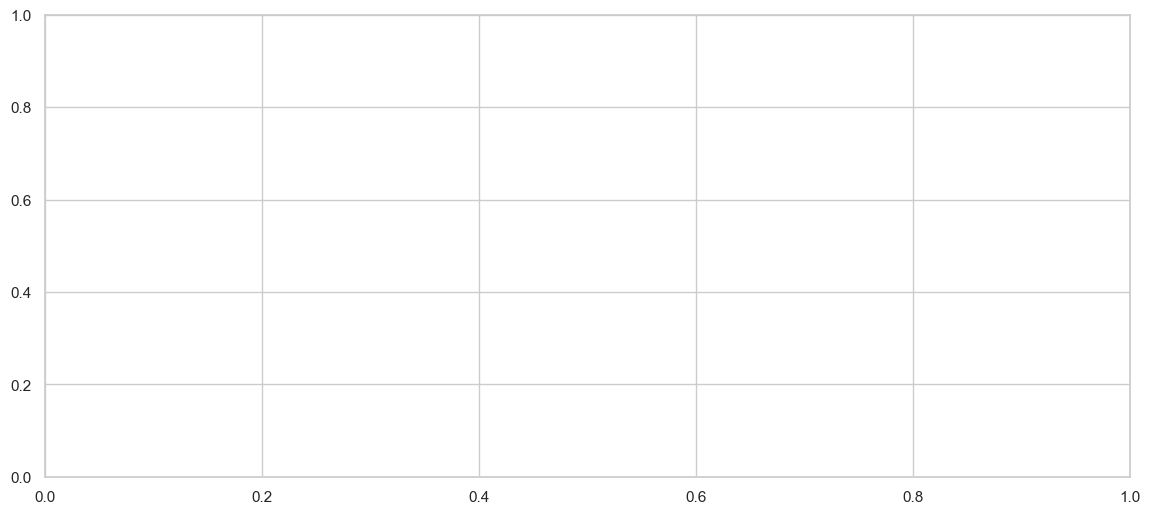

In [ ]:
#togo Solar Data EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from windrose import WindroseAxes

sns.set(style='whitegrid')

# Load data
df = pd.read_csv('togo-dapaong_qc.csv')

# Summary statistics & missing values
print(df.describe())
missing_report = df.isna().sum()
print("\nMissing Values:\n", missing_report[missing_report > 0])
missing_percent = df.isna().mean() * 100
print("\n>5% Missing Columns:\n", missing_percent[missing_percent > 5])

# Outlier detection via Z-score
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols_to_check].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Outliers found: {outliers.sum()}")
df_clean = df[~outliers].copy()

# Impute missing values with median
for col in cols_to_check:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Save cleaned CSV
df_clean.to_csv('togo_dapaong_qc_clean.csv', index=False)

# Time series plots
plt.figure(figsize=(14,6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    sns.lineplot(data=df_clean, x='Timestamp', y=col, label=col)
plt.title('Sierra Leone - Irradiance and Temperature Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Cleaning impact (if applicable)
if 'Cleaning' in df_clean.columns:
    df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
    plt.title('Cleaning Effect on ModA & ModB')
    plt.show()

# Correlation heatmap
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

# Histograms
plt.hist(df_clean['GHI'], bins=30, alpha=0.6, label='GHI')
plt.hist(df_clean['WS'], bins=30, alpha=0.6, label='WS')
plt.legend()
plt.title('Distribution of GHI and WS')
plt.show()

# RH vs Temperature
sns.scatterplot(data=df_clean, x='RH', y='Tamb', hue='GHI')
plt.title('RH vs Tamb colored by GHI')
plt.show()

# Bubble chart: GHI vs Tamb with bubble size = RH
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH'], alpha=0.5)
plt.xlabel("GHI")
plt.ylabel("Tamb")
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.show()
